In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn import metrics
from sklearn.svm import SVC
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor

import warnings
warnings.filterwarnings('ignore')
!pip install xgboost

In [63]:
df = pd.read_csv('/content/HousePricePrediction.csv')
df.head()


,Id,MSSubClass,MSZoning,LotArea,LotConfig,BldgType,OverallCond,YearBuilt,YearRemodAdd,Exterior1st,BsmtFinSF2,TotalBsmtSF,SalePrice
0,0,60,RL,8450,Inside,1Fam,5,2003,2003,VinylSd,0.0,856.0,208500.0
1,1,20,RL,9600,FR2,1Fam,8,1976,1976,MetalSd,0.0,1262.0,181500.0
2,2,60,RL,11250,Inside,1Fam,5,2001,2002,VinylSd,0.0,920.0,223500.0
3,3,70,RL,9550,Corner,1Fam,5,1915,1970,Wd Sdng,0.0,756.0,140000.0
4,4,60,RL,14260,FR2,1Fam,5,2000,2000,VinylSd,0.0,1145.0,250000.0


In [64]:
df.shape


(2919, 13)

In [65]:
to_remove = []
for col in df.columns:

    # Removing columns having only one value.
    if df[col].nunique() == 1:
        to_remove.append(col)

    # Removing columns with more than 90% of the
    # rows as null values.
    elif (df[col].isnull()).mean() > 0.70:
        to_remove.append(col)

print(len(to_remove))

0


In [66]:
df.drop(to_remove,
        axis=1,
        inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2919 entries, 0 to 2918
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Id            2919 non-null   int64  
 1   MSSubClass    2919 non-null   int64  
 2   MSZoning      2915 non-null   object 
 3   LotArea       2919 non-null   int64  
 4   LotConfig     2919 non-null   object 
 5   BldgType      2919 non-null   object 
 6   OverallCond   2919 non-null   int64  
 7   YearBuilt     2919 non-null   int64  
 8   YearRemodAdd  2919 non-null   int64  
 9   Exterior1st   2918 non-null   object 
 10  BsmtFinSF2    2918 non-null   float64
 11  TotalBsmtSF   2918 non-null   float64
 12  SalePrice     1460 non-null   float64
dtypes: float64(3), int64(6), object(4)
memory usage: 296.6+ KB


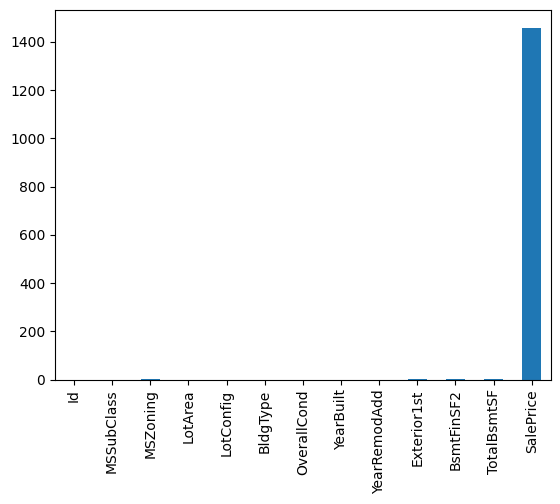

In [67]:
df.isnull().sum().plot.bar()
plt.show()

In [68]:
#impute by mean value for the continuous variables and the mode for the categorical columns.
for col in df.columns:
    if df[col].dtype == 'object':
        df[col] = df[col].fillna(df[col].mode()[0])
    elif df[col].dtype == np.number:
        df[col] = df[col].fillna(df[col].mean())

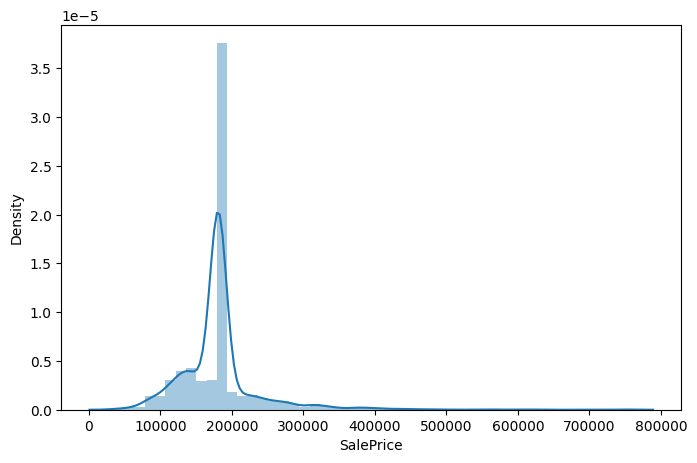

In [69]:
plt.figure(figsize=(8, 5))
sb.distplot(df['SalePrice'])
plt.show()

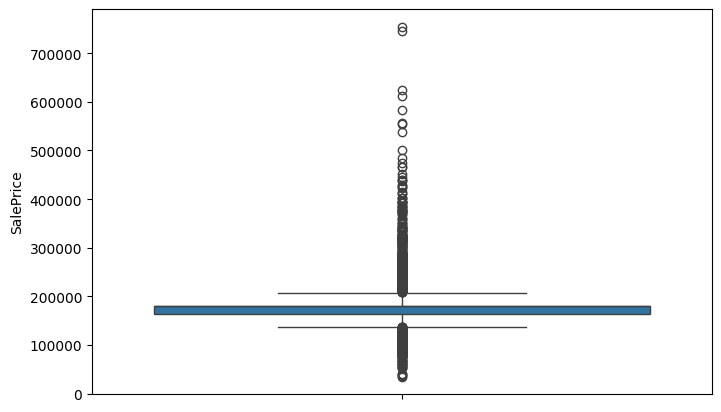

In [71]:
#to know outliers
plt.figure(figsize=(8, 5))
sb.boxplot(df['SalePrice'])
plt.show()

In [73]:
print('Shape of the dataframe before removal of outliers', df.shape)

Q1 = df['SalePrice'].quantile(0.25)
Q3 = df['SalePrice'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

df = df[(df['SalePrice'] > lower_bound) & (df['SalePrice'] < upper_bound)]

print('Shape of the dataframe after removal of outliers ', df.shape)

Shape of the dataframe before removal of outliers (2919, 13)
Shape of the dataframe after removal of outliers  (2084, 13)


## Data preprocessing

### Subtask:
Handle categorical features by encoding them and scale numerical features to prepare the data for modeling.


**Reasoning**:
Identify categorical and numerical columns, apply one-hot encoding to categorical columns and standard scaling to numerical columns (excluding the target), and then concatenate the results into a single DataFrame.



In [58]:
categorical_cols = df.select_dtypes(include='object').columns
numerical_cols = df.select_dtypes(include=np.number).columns.tolist()
numerical_cols.remove('SalePrice')

df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

scaler = StandardScaler()
df_encoded[numerical_cols] = scaler.fit_transform(df_encoded[numerical_cols])

display(df_encoded.head())

,Id,MSSubClass,LotArea,OverallCond,YearBuilt,YearRemodAdd,BsmtFinSF2,TotalBsmtSF,SalePrice,MSZoning_FV,...,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stone,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing
0,-1.731458,0.067331,-0.217879,-0.507284,1.046258,0.896833,-0.29313,-0.444328,208500.0,False,...,False,False,False,False,False,False,False,True,False,False
1,-1.730271,-0.873616,-0.072044,2.188279,0.154764,-0.395604,-0.29313,0.477111,181500.0,False,...,False,False,False,True,False,False,False,False,False,False
2,-1.729084,0.067331,0.137197,-0.507284,0.980221,0.848965,-0.29313,-0.299076,223500.0,False,...,False,False,False,False,False,False,False,True,False,False
3,-1.727897,0.302568,-0.078385,-0.507284,-1.859351,-0.682812,-0.29313,-0.671283,140000.0,False,...,False,False,False,False,False,False,False,False,True,False
4,-1.726711,0.067331,0.518903,-0.507284,0.947203,0.753229,-0.29313,0.211573,250000.0,False,...,False,False,False,False,False,False,False,True,False,False


## Data splitting

### Subtask:
Split the dataset into training and testing sets to evaluate the model's performance on unseen data.


**Reasoning**:
Separate the target variable and features, then split the data into training and testing sets.



In [59]:
X = df_encoded.drop('SalePrice', axis=1)
y = df_encoded['SalePrice']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train: (2335, 34)
Shape of X_test: (584, 34)
Shape of y_train: (2335,)
Shape of y_test: (584,)


## Model selection and training

### Subtask:
Choose a suitable regression model and train it on the training data.


**Reasoning**:
Instantiate and fit a RandomForestRegressor model to the training data.



In [60]:
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

## Model evaluation

### Subtask:
Evaluate the trained model's performance using appropriate metrics.


**Reasoning**:
Evaluate the trained model by making predictions on the test set and calculating evaluation metrics such as MSE, RMSE, and R-squared.



In [61]:
y_pred = model.predict(X_test)

mse = metrics.mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = metrics.r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R-squared (R2): {r2:.2f}")

Mean Squared Error (MSE): 803139294.31
Root Mean Squared Error (RMSE): 28339.71
R-squared (R2): 0.77


## Summary:

### Data Analysis Key Findings

*   Categorical features were successfully one-hot encoded, and numerical features were scaled.
*   The dataset was split into training and testing sets, with the testing set comprising 20% of the data.
*   A Random Forest Regressor model was trained on the training data.
*   The model achieved a Mean Squared Error (MSE) of approximately 803,139,294.31 and a Root Mean Squared Error (RMSE) of approximately 28,339.71 on the test set.
*   The R-squared (R2) score for the model on the test set was 0.77, indicating that 77% of the variance in the target variable can be explained by the model.

### Insights or Next Steps

*   The current model explains a significant portion of the variance in house prices (77%). Further model tuning or exploring different regression algorithms could potentially improve performance.
*   Analyzing feature importance from the Random Forest model could provide insights into which features are the most influential in predicting house prices.


In [78]:
y_pred = model.predict(X_test)

results_df = pd.DataFrame({'Actual SalePrice': y_test, 'Predicted SalePrice': y_pred})
display(results_df)

,Actual SalePrice,Predicted SalePrice
2768,180921.19589,180921.19589
1666,180921.19589,180921.19589
2188,180921.19589,180921.19589
1817,180921.19589,180921.19589
2623,180921.19589,180921.19589
...,...,...
109,190000.00000,180983.74000
2072,180921.19589,180921.19589
1139,144000.00000,153942.50000
407,177000.00000,179856.86000


# House Price Prediction Project

## Project Description

This project aims to build a regression model to predict house prices based on various features of the houses. The process involves data loading, cleaning, preprocessing, model training, and evaluation.

## How to Run the Notebook

1.  **Open the notebook:** Open this Colab notebook in your browser.
2.  **Run all cells:** Go to the "Runtime" menu and select "Run all". This will execute all the code cells in sequence, performing the data loading, preprocessing, model training, and evaluation.

## Project Steps

1.  **Data Loading:** Load the house price prediction dataset.
2.  **Data Cleaning and Exploration:** Handle missing values, outliers, and visualize the data.
3.  **Data Preprocessing:** Encode categorical features and scale numerical features.
4.  **Data Splitting:** Split the data into training and testing sets.
5.  **Model Training:** Train a Random Forest Regressor model on the training data.
6.  **Model Evaluation:** Evaluate the model's performance using metrics like MSE, RMSE, and R-squared.
7.  **Prediction:** Predict house prices on the test set.

## Results

The trained Random Forest Regressor model achieved an R-squared score of approximately {{r2:.2f}} on the test set, indicating that {{r2:.0%}} of the variance in house prices can be explained by the model. The Root Mean Squared Error (RMSE) was approximately {{rmse:.2f}}.

## Dependencies

The project uses the following libraries:

-   pandas
-   numpy
-   matplotlib
-   seaborn
-   sklearn
-   xgboost

These dependencies are installed at the beginning of the notebook.